### Create Database (PostgreSQL)

Базу создал в десктоп-приложении pgAdmin 4. Создадим таблицы.

```
    CREATE SCHEMA gb_rwd;
    
    -- Таблица vocabulary
    CREATE TABLE gb_rwd.vocabulary (
      concept_id SERIAL PRIMARY KEY,  -- первичный ключ
      concept_name VARCHAR(255),
      domain VARCHAR(150),
      code VARCHAR(150)
    );
    
    -- Таблица person
    CREATE TABLE gb_rwd.person (
      person_id SERIAL PRIMARY KEY,  -- первичный ключ
      date_of_birth DATE,
      sex_concept_id INT REFERENCES gb_rwd.vocabulary(concept_id),  -- внешней ключ
      hospital_days INT
    );
    
    -- Таблица measurement
    CREATE TABLE gb_rwd.measurement (
      measurement_id SERIAL PRIMARY KEY,  -- первичный ключ
      measurement_concept_id INT REFERENCES gb_rwd.vocabulary(concept_id),  -- внешней ключ
      measurement_date DATE,
      value FLOAT,
      person_id INT REFERENCES gb_rwd.person(person_id)  -- внешней ключ
    );
    
    -- Таблица condition
    CREATE TABLE gb_rwd.condition (
      condition_id SERIAL PRIMARY KEY,  -- первичный ключ
      condition_concept_id INT REFERENCES gb_rwd.vocabulary(concept_id),  -- внешней ключ
      condition_date DATE,
      person_id INT REFERENCES gb_rwd.person(person_id)  -- внешней ключ
    );
    
    -- Таблица drug
    CREATE TABLE gb_rwd.drug (
      drug_id SERIAL PRIMARY KEY,  -- первичный ключ
      drug_concept_id INT REFERENCES gb_rwd.vocabulary(concept_id),  -- внешней ключ
      drug_date DATE,
      person_id INT REFERENCES gb_rwd.person(person_id)  -- внешней ключ
    );
    
    -- Таблица procedure
    CREATE TABLE gb_rwd.procedure (
      procedure_id SERIAL PRIMARY KEY,  -- первичный ключ
      procedure_concept_id INT REFERENCES gb_rwd.vocabulary(concept_id),  -- внешней ключ
      procedure_date DATE,
      person_id INT REFERENCES gb_rwd.person(person_id)  -- внешней ключ
    );
```

### CSV to Databse

In [3]:
import warnings
warnings.filterwarnings("ignore")
import re
from re import sub, search, findall
import pandas  as pd
from datetime import datetime
import numpy as np
import glob
import os

In [5]:
# dates
def epi_dates_preparation(strng):
  data_1 =  sub(r'(0?[1-9]|[12]\d|30|31)[.](0?[1-9]|1[0-2])[.](\d{4})',
                '\\1-\\2-\\3', strng)
  return sub(r'(0?[1-9]|[12]\d|30|31)[.](0?[1-9]|1[0-2])[.](\d{2})',
             '\\1-\\2-20\\3', data_1)

In [7]:
def read_txt(ff):
  with open(ff, encoding='utf-8', errors='ignore') as f:
    f = f.read()
    return f

In [8]:
# gender
def get_gender(file_):
  file_ = sub('диагноз.*', '', file_)
  if 'вна' in file_:
    return 25
  else:
    return 26

In [10]:
# remove extra
def remover(file_):
  file_ = ''.join(file_.split()).lower()
  stop_element = [',',':', '/t', 'менее']
  for elem in stop_element:
    if elem == ',':
      file_ = sub(elem, '.', file_)
    else:
      file_ = sub(elem, '', file_)
  return file_

In [11]:
def preparator(path):
  def inner_preparator(fun):
    def wrapper(*args, **kwargs):
      txt2 = epi_dates_preparation(remover(read_txt(path)))
      return fun(txt2)
    return wrapper
  return inner_preparator

In [111]:
# files
lst_of_txts = list(glob.glob(os.path.join('data/rwd_raw', '*.txt')))
lst_of_txts[:5]

['data/rwd_raw\\file (1067).txt',
 'data/rwd_raw\\file (1068).txt',
 'data/rwd_raw\\file (1069).txt',
 'data/rwd_raw\\file (107).txt',
 'data/rwd_raw\\file (1070).txt']

In [13]:
len(lst_of_txts)

34

In [14]:
patient_ids = list(map(lambda file_: int(search(r'\d+', file_)[0]), lst_of_txts))
list_of_epi = list(map(lambda file_: epi_dates_preparation(remover(read_txt(file_))) , lst_of_txts))
gender_list = list(map(lambda file_: get_gender(epi_dates_preparation(remover(read_txt(file_)))) , lst_of_txts))

In [109]:
gender_list[:10]

[25, 25, 25, 25, 25, 25, 25, 25, 26, 26]

#### Person

In [103]:
def prepare_person_table(gender_list, list_of_epi, patient_ids, hospital_days = [], date_of_birth = []):
    for file_ in list_of_epi:
        admission = findall('\d{2}-\d{2}-\d{4}', file_)[1]
        discharge = findall('\d{2}-\d{2}-\d{4}', file_)[-1]
        hospital_days.append(
            datetime.strptime(discharge, '%d-%m-%Y').date() -
            datetime.strptime(admission, '%d-%m-%Y').date())
        date_of_birth.append(findall('\d{2}-\d{2}-\d{4}', file_)[0])
    data_dct = {'person_id ': patient_ids, 'date_of_birth': date_of_birth, 'hospital_days':hospital_days,'sex_concept_id ': gender_list}
    df = pd.DataFrame(data_dct)
    df = df.replace(r'', np.nan, regex=True)
    df['hospital_days'] = df['hospital_days'].dt.days.astype('int16')
    df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], format='%d-%m-%Y')
    return df

In [104]:
patient_table = prepare_person_table(
    gender_list = gender_list,
    list_of_epi = list_of_epi,
    patient_ids = patient_ids
)

patient_table.head()

,person_id,date_of_birth,hospital_days,sex_concept_id
0,1067,1978-11-11,11,25
1,1068,1952-03-28,17,25
2,1069,1962-11-02,17,25
3,107,1938-02-24,17,25
4,1070,1959-11-10,50,25


In [44]:
patient_table.to_csv('db_epicrisis/person.csv', index=False)

#### Measurement

In [25]:
measurements_map = {
    'фибриноген': {'гемостазиограмма': 6},
    'креатинин': {'биохимическое исследование крови': 7},
    'лейкоциты': {'общий анализ крови': 8},
    'гемоглобин': {'общий анализ крови': 9},
    'тромбоциты': {'общий анализ крови': 10},
    '.-реактивный белок': {'биохимическое исследование крови': 11},
    'соэ': {'общий анализ крови': 12},
    'лимфоциты': {'общий анализ крови': 13},
    'прокальцитонин': {'ифа анализ': 27}
}

In [26]:
for measurement_name , sub_dict in measurements_map.items():
    for measurement_type, measurement_concept_id_ in sub_dict.items():
      print(sub_dict, measurement_concept_id_)

{'гемостазиограмма': 6} 6
{'биохимическое исследование крови': 7} 7
{'общий анализ крови': 8} 8
{'общий анализ крови': 9} 9
{'общий анализ крови': 10} 10
{'биохимическое исследование крови': 11} 11
{'общий анализ крови': 12} 12
{'общий анализ крови': 13} 13
{'ифа анализ': 27} 27


In [27]:
def measurements_template(
    list_of_epicrisis,
    patient_ids,
    measurements_map,
    measurement_id = [],
    measurement_date  = [],
    measurement_concept_id = [],
    patient_id = [],
    value = []
    ):
  for measurement_name , sub_dict in measurements_map.items():
    for measurement_type, concept_id in sub_dict.items():
        for file_, patient_id_ in zip(list_of_epicrisis, patient_ids):
            pattern0 = ''.join(['r(\d{2}-\d{2}-\d{4})(', measurement_type, ')'])
            file_ = sub(pattern0, r'\2\1', file_)
            pattern1 = ''.join(['(?<=', measurement_type, ')', '(\d{2}-\d{2}-\d{4}|)'])
            for date in findall(pattern1, file_):
              measurement_date .append(date)
              patient_id.append(patient_id_)
              measurement_concept_id.append(concept_id)
            pattern2 = ''.join(['(', measurement_type, ')', '(\d{2}-\d{2}-\d{4}|)'])
            file_1 = sub(pattern2, r'\2\1', file_)
            pattern3 = ''.join(['(', measurement_type, '.*?)', '(?=\d{2}-\d{2}-\d{4})'])
            for value_ in findall(pattern3, file_1):
              value_ = sub(''.join(['(.*)(', measurement_name, ')', '(\d.\d*)']), r'\3\2\1', value_)
              value_ = sub(''.join(['(', measurement_name, '|', measurement_type, ').*']) , '', value_)
              value_ = re.sub('[^0-9.]|х10|x10', '', value_)

              if value_:
                  value.append(value_)
              else:
                  value.append('NA')

  data_dct = {'person_id': patient_id, 'measurement_concept_id': measurement_concept_id,
                      'measurement_date': measurement_date ,'value': value}
  df = pd.DataFrame.from_dict(data_dct, orient='index')

  df = df.transpose()
  df['measurement_id'] = df.index + 1
  df = df[df.measurement_date != '']
  df = df[df.value != 'NA']
  df['measurement_date'] = pd.to_datetime(df.measurement_date)

  return df

In [100]:
patient_ids = list(map(lambda file_: int(search(r'\d+', file_)[0]), lst_of_txts))
list_of_epi = list(map(lambda file_: epi_dates_preparation(remover(read_txt(file_))) , lst_of_txts))
measurement_data = measurements_template(list_of_epicrisis = list_of_epi, patient_ids = patient_ids, measurements_map = measurements_map)
measurement_data.head()

,person_id,measurement_concept_id,measurement_date,value,measurement_id
0,1067,6,2020-12-14,4.8,1
1,1068,6,2020-12-14,6.38,2
2,1069,6,2020-12-13,5.9,3
3,107,6,2021-01-20,2.42,4
4,107,6,2021-01-21,4,5


In [29]:
measurement_data.to_csv('db_epicrisis/measurements.csv', index=False)

#### Drug

In [94]:
treatment_map = {
    "лизиноприл": {"л.з.....ил|лизитар|лизинеоприл|лизоретик|диротон": 20},
    "цефтриаксон": {"три.....ф|цефт.....он|цефтриакосн": 16},
    "бисопролол": {"б.с.пр..ол|бисопралдол|бикард|конкор": 21},
    "аспирин": {"аспкиард|кардиомагнил|ас....рд": 22},
    "дексаметазон": {"декс.......н|дексаетазон": 15},
    "азитромицин": {"азит.......": 18},
    "гепарин": {"гепарин": 19}
}

In [31]:
def treatment_detection(
    list_of_epicrisis,
    patient_ids,
    treatment_map,
    drug_date  = [],
    drug_concept_id = [],
    patient_id = []
    ):
  for drug_name , sub_dct in treatment_map.items():
    for variations, drug_id in    sub_dct.items():
      for file_, patient_id_ in zip(list_of_epicrisis, patient_ids):
        file_ = sub(variations, drug_name, file_)
        if drug_name in  file_:
          drug_date.append(findall('\d{2}-\d{2}-\d{4}', file_)[-1])
          drug_concept_id.append(drug_id)
          patient_id.append(patient_id_)
    data_dct = {'person_id': patient_id, 'drug_concept_id': drug_concept_id,
                      'drug_date': drug_date }
  df = pd.DataFrame(data_dct)
  df['drug_id'] = df.index + 1
  df['drug_date'] = pd.to_datetime(df.drug_date)
  return(df)

In [32]:
drug_data = treatment_detection(
    list_of_epicrisis = list_of_epi,
    patient_ids = patient_ids,
    treatment_map = treatment_map
)

In [99]:
drug_data.head()

,person_id,drug_concept_id,drug_date,drug_id
0,1073,20,2020-12-24,1
1,1079,20,2021-01-12,2
2,1097,20,2021-01-14,3
3,1070,16,2021-02-01,4
4,1072,16,2020-12-18,5


In [34]:
drug_data.to_csv('db_epicrisis/drugs.csv', index=False)

### Conditions

In [41]:
condition_procedures_map = {
    1:	{'Внегоспитальная пневмония': 'пне...ния|внегоспитальная|внебольничная'},
    2:	{'Ишемическая болезнь сердца': 'ссн|ибс|атеросклеротический|кардиосклероз|фп|фибрил....' },
    3:	{'Сахарный диабет': 'д.абет|сдтип|сд2|сд1|сах.....'},
    4:	{'Коронавирусная инфекция': 'covid19|коронавирусная|b34|sarscov2'},
    5:	{'Артериальная гипертензия': 'аг\d|агi|артериальнаягипер '},
    23:	{'Рентгелологическое исследование грудной клетки': 'rgогк|ргогк'},
    24:	{'Электрокардиография': 'экг|электрокардио'}
}

In [42]:
def condition_detection(
    list_of_epicrisis,
    patient_ids,
    condition_map,
    condition_date  = [],
    condition_concept_id = [],
    patient_id = []
    ):
  for concept_id , sub_dct in condition_map.items():
    if concept_id < 6:
      for condition, variations in  sub_dct.items():
        for file_, patient_id_ in zip(list_of_epicrisis, patient_ids):
          file_ = sub(variations, condition, file_)
          if condition in  file_:
            condition_date.append(findall('\d{2}-\d{2}-\d{4}', file_)[-1])
            condition_concept_id.append(concept_id)
            patient_id.append(patient_id_)
    data_dct = {'person_id': patient_id, 'condition_concept_id': condition_concept_id,
                      'condition_date': condition_date }
  df = pd.DataFrame(data_dct)
  df['condition_id'] = df.index + 1
  df['condition_date'] = pd.to_datetime(df.condition_date)
  return(df)

In [43]:
condition_data = condition_detection(
    list_of_epicrisis = list_of_epi,
    patient_ids = patient_ids,
    condition_map = condition_procedures_map
)
condition_data.to_csv('db_epicrisis/conditions.csv', index=False)

In [38]:
def procedures_detection(
    list_of_epicrisis,
    patient_ids,
    procedure_map,
    procedure_date  = [],
    procedure_concept_id = [],
    patient_id = []
    ):
  for concept_id , sub_dct in procedure_map.items():
    if concept_id > 6:
      for procedure, variations in  sub_dct.items():
        for file_, patient_id_ in zip(list_of_epicrisis, patient_ids):
          file_ = sub(variations, procedure, file_)
          if procedure in  file_:
            procedure_date.append(findall('\d{2}-\d{2}-\d{4}', file_)[-1])
            procedure_concept_id.append(concept_id)
            patient_id.append(patient_id_)
    data_dct = {'person_id': patient_id, 'procedure_concept_id': procedure_concept_id,
                      'procedure_date': procedure_date}
  df = pd.DataFrame(data_dct)
  df['procedure_id'] = df.index + 1
  df['procedure_date'] = pd.to_datetime(df.procedure_date)
  return(df)

In [40]:
procedures_data = procedures_detection(
    list_of_epicrisis = list_of_epi,
    patient_ids = patient_ids,
    procedure_map = condition_procedures_map
)
procedures_data.to_csv('db_epicrisis/procedures.csv', index=False)

Имеем все необходимые файлы: dictionary.csv (по умолчанию), person.csv, measurements.csv, conditions.csv, drugs.csv, procedures.csv.

Теперь вызовем нашу базу данных (epicrisis) и заполним ее полученными данными.

In [95]:
# для коннекта установим модуль
# !pip install psycopg2-binary

In [46]:
import psycopg2
from psycopg2 import OperationalError

Для демонстрации придумаю юзера и пароль. Чекнем базу на существование.

In [74]:
# Параметры подключения
connection_params = {
    'dbname': 'epicrisis',
    'user': 'test_user',
    'password': '12345678',
    'host': 'localhost',
    'port': '5432'
}

def check_postgresql_connection(params):
    try:
        # Попытка соединения с базой данных
        connection = psycopg2.connect(
            host=params['host'],
            port=params['port'],
            database=params['dbname'],
            user=params['user'],
            password=params['password']
        )
        # Если соединение успешно, выводим информацию
        print("PostgreSQL database connection successful")
        connection.close()
    except OperationalError as e:
        # Если соединение не удалось, выводим сообщение об ошибке
        print(f"Unable to connect to the database: {e}")
        
check_postgresql_connection(connection_params)

PostgreSQL database connection successful


In [75]:
# проверка на существование записи
def record_exists(cursor, schema, table, unique_column, value):
    query = sql.SQL("SELECT EXISTS(SELECT 1 FROM {schema}.{table} WHERE {unique_column} = %s)").format(
        schema=sql.Identifier(schema),
        table=sql.Identifier(table),
        unique_column=sql.Identifier(unique_column)
    )
    cursor.execute(query, (value,))
    return cursor.fetchone()[0]

Заливаем файл в базу.

In [80]:
from psycopg2 import sql

def load_csv_to_db(csv_file, schema, table_name, connection_params, conflict_column, encoding='utf-8', sep=','):
    # Подключаемся к базе данных
    conn = psycopg2.connect(**connection_params)
    cursor = conn.cursor()

    try:
        # Загружаем CSV в DataFrame
        df = pd.read_csv(csv_file, encoding=encoding, sep=sep)
    except UnicodeDecodeError as e:
        print(f"Ошибка декодирования: {e}")
        return
    
    # Удаляем лишние пробелы в названиях столбцов
    df.columns = [col.strip() for col in df.columns]
    
    columns = df.columns.tolist()

    # Подготавливаем запрос на вставку
    insert_query = sql.SQL("""
        INSERT INTO {schema}.{table} ({fields}) 
        VALUES ({values}) 
        ON CONFLICT ({conflict_column}) DO NOTHING
    """).format(
        schema=sql.Identifier(schema),
        table=sql.Identifier(table_name),
        fields=sql.SQL(', ').join(map(sql.Identifier, columns)),
        values=sql.SQL(', ').join(sql.Placeholder() * len(columns)),
        conflict_column=sql.Identifier(conflict_column)
    )

    # Итерируем по строкам DataFrame и вставляем данные
    for index, row in df.iterrows():
        values = tuple(row)
        cursor.execute(insert_query, values)

    # Сохраняем изменения и закрываем соединение
    conn.commit()
    cursor.close()
    conn.close()

In [81]:
# 1. Vocabulary
load_csv_to_db('db_epicrisis/vocabulary.csv', 'gb_rwd', 'vocabulary', connection_params, 'concept_id', sep=';')

In [82]:
# 2. Person
load_csv_to_db('db_epicrisis/person.csv', 'gb_rwd', 'person', connection_params, conflict_column='person_id')

In [83]:
# 3. Measurement
load_csv_to_db('db_epicrisis/measurements.csv', 'gb_rwd', 'measurement', connection_params, conflict_column='measurement_id')

In [84]:
# 4. Condition
load_csv_to_db('db_epicrisis/conditions.csv', 'gb_rwd', 'condition', connection_params, conflict_column='condition_id')

In [85]:
# 5. Drug
load_csv_to_db('db_epicrisis/drugs.csv', 'gb_rwd', 'drug', connection_params, conflict_column='drug_id')

In [86]:
# 6. Procedure
load_csv_to_db('db_epicrisis/procedures.csv', 'gb_rwd', 'procedure', connection_params, conflict_column='procedure_id')

### ERD

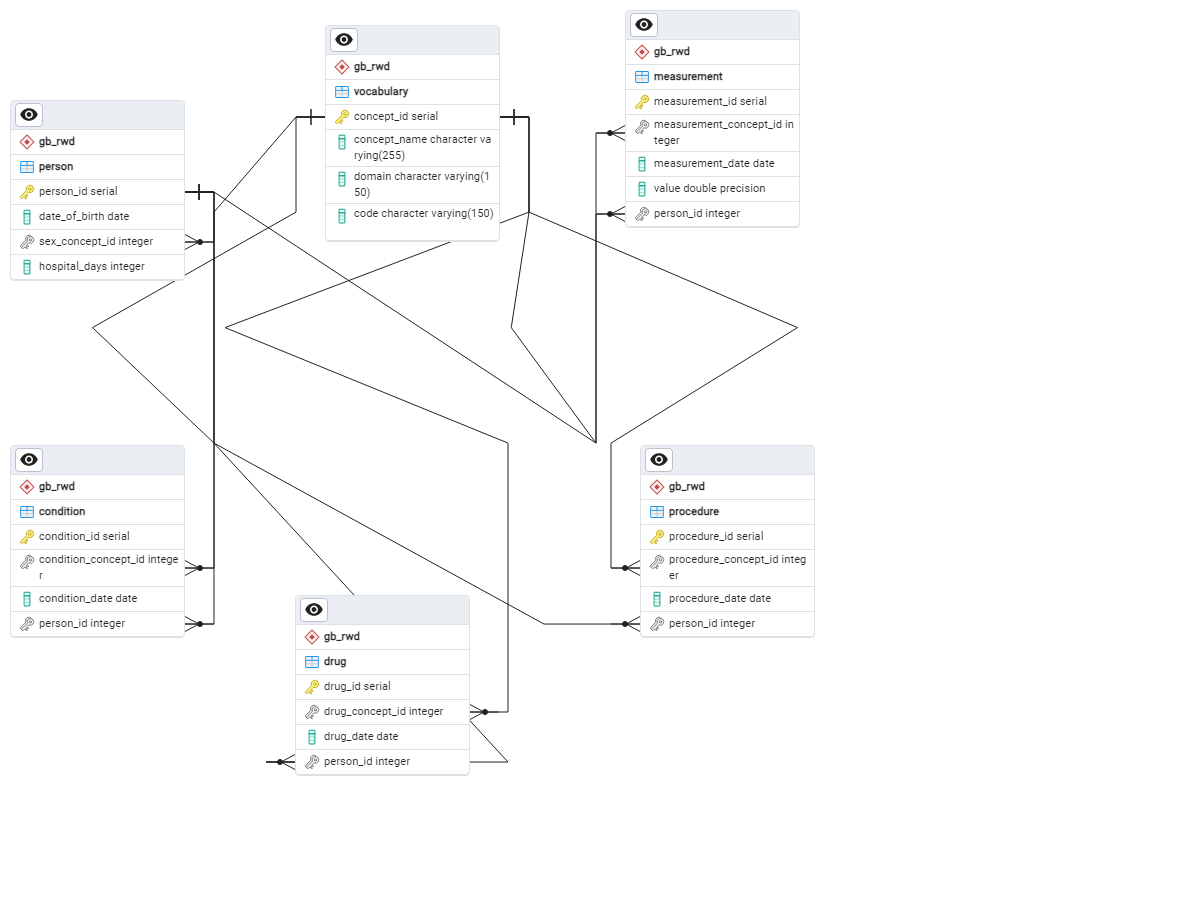

In [88]:
from PIL import Image
from IPython.display import display

img = Image.open('erd.png')

display(img)

### Data Demonstration (выгрузка с postgre)

In [89]:
def fetch_table_data(schema, table_name, connection_params):
    # Подключаемся к базе данных
    conn = psycopg2.connect(**connection_params)
    cursor = conn.cursor()
    
    # Формируем SQL-запрос для извлечения всех данных из таблицы
    query = f"SELECT * FROM {schema}.{table_name};"
    
    # Выполняем запрос
    cursor.execute(query)
    
    # Получаем все строки из результата запроса
    rows = cursor.fetchall()
    
    # Получаем имена столбцов
    colnames = [desc[0] for desc in cursor.description]
    
    # Закрываем курсор и соединение
    cursor.close()
    conn.close()
    
    # Создаем DataFrame и возвращаем его
    df = pd.DataFrame(rows, columns=colnames)
    return df

In [91]:
vocabulary_pd = fetch_table_data('gb_rwd', 'vocabulary', connection_params)
vocabulary_pd.head()

,concept_id,concept_name,domain,code
0,1,Внегоспитальная пневмония,Заболевание,J18
1,2,Ишемическая болезнь сердца,Заболевание,I25
2,3,Сахарный диабет,Заболевание,E11
3,4,Коронавирусная инфекция,Заболевание,U07
4,5,Артериальная гипертензия,Заболевание,I10


In [92]:
condition_pd = fetch_table_data('gb_rwd', 'condition', connection_params)
condition_pd.head()

,condition_id,condition_concept_id,condition_date,person_id
0,1,1,2020-12-24,1067
1,2,1,2020-12-30,1068
2,3,1,2020-12-30,1069
3,4,1,2021-02-01,1070
4,5,1,2020-12-31,1071


In [93]:
drug_pd = fetch_table_data('gb_rwd', 'drug', connection_params)
drug_pd.head()

,drug_id,drug_concept_id,drug_date,person_id
0,1,20,2020-12-24,1073
1,2,20,2021-01-12,1079
2,3,20,2021-01-14,1097
3,4,16,2021-02-01,1070
4,5,16,2020-12-18,1072


In [96]:
procedure_pd = fetch_table_data('gb_rwd', 'procedure', connection_params)
procedure_pd.head()

,procedure_id,procedure_concept_id,procedure_date,person_id
0,1,23,2021-01-27,1074
1,2,24,2021-02-05,107
2,3,24,2020-12-31,1071
3,4,24,2021-02-10,108
4,5,24,2020-12-21,1083


In [97]:
measurement_pd = fetch_table_data('gb_rwd', 'measurement', connection_params)
measurement_pd.head()

,measurement_id,measurement_concept_id,measurement_date,value,person_id
0,1,6,2020-12-14,4.80,1067
1,2,6,2020-12-14,6.38,1068
2,3,6,2020-12-13,5.90,1069
3,4,6,2021-01-20,2.42,107
4,5,6,2021-01-21,4.00,107


In [98]:
person_pd = fetch_table_data('gb_rwd', 'person', connection_params)
person_pd.head()

,person_id,date_of_birth,sex_concept_id,hospital_days
0,1067,1978-11-11,25,11
1,1068,1952-03-28,25,17
2,1069,1962-11-02,25,17
3,107,1938-02-24,25,17
4,1070,1959-11-10,25,50
